In [3]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [4]:
from tensorflow.python.keras.applications.vgg16 import VGG16
pretrained_base =VGG16(include_top=False, weights=None, input_tensor=None,
           input_shape=(128,128,3))
pretrained_base.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
pretrained_base.trainable = False


In [5]:
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model=keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    #augmentation
    #preprocessing.RandomFlip('horizontal'),
    #preprocessing.RandomContrast(0.5),
    #preprocessing.RandomRotation(factor=0.2),
    #base
    pretrained_base,
    #head
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1,activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
early = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='auto')


history=model.fit(
    ds_train,
    validation_data=ds_valid,
    callbacks=[early],
    epochs=500,
)

Epoch 1/500
80/80 [==============================] - 69s 726ms/step - loss: 0.9996 - binary_accuracy: 0.6176 - val_loss: 0.4188 - val_binary_accuracy: 0.8028
Epoch 2/500
80/80 [==============================] - 6s 79ms/step - loss: 0.4014 - binary_accuracy: 0.8233 - val_loss: 0.3597 - val_binary_accuracy: 0.8481
Epoch 3/500
80/80 [==============================] - 6s 78ms/step - loss: 0.3247 - binary_accuracy: 0.8591 - val_loss: 0.3406 - val_binary_accuracy: 0.8495
Epoch 4/500
80/80 [==============================] - 6s 79ms/step - loss: 0.2794 - binary_accuracy: 0.8868 - val_loss: 0.3304 - val_binary_accuracy: 0.8567
Epoch 5/500
80/80 [==============================] - 6s 78ms/step - loss: 0.2570 - binary_accuracy: 0.8891 - val_loss: 0.3817 - val_binary_accuracy: 0.8329
Epoch 6/500
80/80 [==============================] - 6s 80ms/step - loss: 0.2430 - binary_accuracy: 0.8985 - val_loss: 0.5217 - val_binary_accuracy: 0.7555
Epoch 7/500
80/80 [==============================] - 6s 79ms/s

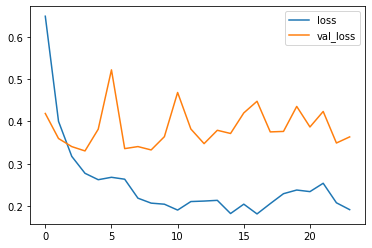

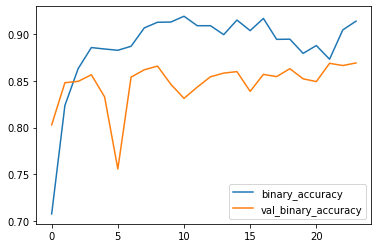

In [6]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();